In [1]:

# Result : 0.52 Loss

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from bisect import bisect_left, bisect_right
from torch.utils.data import TensorDataset, DataLoader

In [2]:
def read_csv(file_name):
    train_data = pd.read_csv(file_name)
    X = train_data.iloc[:, 1:-1]
    y = train_data.iloc[:, -1]
    return X, y

In [3]:
file_name = "train.csv"
train_data_X, train_data_y = read_csv(file_name)

In [4]:
for i in train_data_X:
    value = pd.value_counts(train_data_X[i].isna())
    if (value[False] < len(train_data_y)):
        print(value)

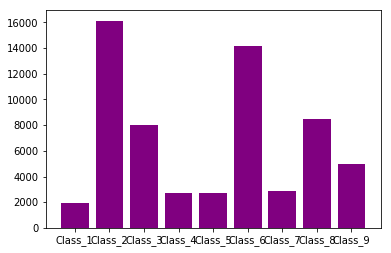

In [5]:
x = ["Class_" + str(i) for i in range(1, 10)]
y = [bisect_right(train_data_y, "Class_" + str(i)) - bisect_left(train_data_y, "Class_" + str(i)) for i in range(1, 10)]
plt.bar(x, y, color="purple")
plt.show()

In [6]:
word_to_ix = dict()
for class_value in x:
    word_to_ix[class_value] = int(class_value[-1]) - 1
print(word_to_ix)
for i, v in enumerate(train_data_y):
    train_data_y[i] = word_to_ix[v]

{'Class_1': 0, 'Class_2': 1, 'Class_3': 2, 'Class_4': 3, 'Class_5': 4, 'Class_6': 5, 'Class_7': 6, 'Class_8': 7, 'Class_9': 8}


In [7]:
X_train = torch.from_numpy(train_data_X.values.astype(np.float32))
y_train = torch.from_numpy(train_data_y.values.astype(np.int64))

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self, feature_size):
        super(AutoEncoder, self).__init__()
        self.fc1 = Encoder(feature_size)
        self.fc2 = Decoder(feature_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [9]:
class Encoder(nn.Module):
    def __init__(self, feature_size):
        super(Encoder, self).__init__()
        first_size = (feature_size // 4) * 3
        latent_size = feature_size // 2
        self.fc1 = nn.Linear(feature_size, first_size)
        self.bn1 = nn.BatchNorm1d(first_size)
        self.fc2 = nn.Linear(first_size, latent_size)
        self.bn2 = nn.BatchNorm1d(latent_size)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        return x

In [10]:
class Decoder(nn.Module):
    def __init__(self, feature_size):
        super(Decoder, self).__init__()
        first_size = (feature_size // 4) * 3
        latent_size = feature_size // 2
        self.fc1 = nn.Linear(latent_size, first_size)
        self.bn1 = nn.BatchNorm1d(first_size)
        self.fc2 = nn.Linear(first_size, feature_size)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.fc2(x)
        return x

In [11]:
class Neural_Network(nn.Module):
    def __init__(self, feature_size):
        super(Neural_Network, self).__init__()
        self.fc1 = nn.Linear(feature_size // 2, 32)
        self.bn1 = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(32, 16)
        self.bn2 = nn.BatchNorm1d(16)
        self.fc3 = nn.Linear(16, 9)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return F.log_softmax(x, dim = 1)

In [12]:
loader_AE = DataLoader(TensorDataset(X_train, X_train), batch_size = 256, shuffle=True)
network_AE = AutoEncoder(X_train.shape[1])
optimizer_AE = torch.optim.Adam(network_AE.parameters(), 2e-3)
criterion_AE = nn.MSELoss()

loader_NN = DataLoader(TensorDataset(X_train, y_train), batch_size = 256, shuffle=True)
network_NN = Neural_Network(X_train.shape[1])
optimizer_NN = torch.optim.Adam(network_NN.parameters(), 2e-3)
criterion_NN = nn.NLLLoss()

print(network_AE)
print(network_NN)

AutoEncoder(
  (fc1): Encoder(
    (fc1): Linear(in_features=93, out_features=69, bias=True)
    (bn1): BatchNorm1d(69, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=69, out_features=46, bias=True)
    (bn2): BatchNorm1d(46, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc2): Decoder(
    (fc1): Linear(in_features=46, out_features=69, bias=True)
    (bn1): BatchNorm1d(69, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=69, out_features=93, bias=True)
  )
)
Neural_Network(
  (fc1): Linear(in_features=46, out_features=32, bias=True)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=16, out_features=9, bias=True)
)


In [13]:
iterations_AE = []
loss_graph_AE = []
# Training AutoEncoder
i = 0
n = 300
for epoch in range(n):
    for x_batch, y_batch in loader_AE:
        optimizer_AE.zero_grad()
        outputs = network_AE(x_batch)
        loss = criterion_AE(outputs, x_batch)
        loss.backward()
        optimizer_AE.step()
        if (i % 50 == 0):
            iterations_AE.append(i)
            loss_graph_AE.append(loss.item())
        if (i % 5000 == 0):
            print("Epoch %d, Iterations %d, Loss = %.3f" % (epoch, i, loss.item()))
        i += 1

Epoch 0, Iterations 0, Loss = 6.166
Epoch 20, Iterations 5000, Loss = 0.522
Epoch 41, Iterations 10000, Loss = 0.323
Epoch 61, Iterations 15000, Loss = 0.619
Epoch 82, Iterations 20000, Loss = 0.330
Epoch 103, Iterations 25000, Loss = 0.320
Epoch 123, Iterations 30000, Loss = 0.411
Epoch 144, Iterations 35000, Loss = 0.317
Epoch 165, Iterations 40000, Loss = 0.269
Epoch 185, Iterations 45000, Loss = 0.258
Epoch 206, Iterations 50000, Loss = 0.378
Epoch 227, Iterations 55000, Loss = 0.271
Epoch 247, Iterations 60000, Loss = 0.270
Epoch 268, Iterations 65000, Loss = 0.319
Epoch 289, Iterations 70000, Loss = 0.351


In [14]:
iterations_NN = []
loss_graph_NN = []
iter_acc = []
acc_NN = []
# Training Model
i = 0
network_AE.eval()
for epoch in range(n):
    j = 0
    for x_batch, y_batch in loader_NN:
        optimizer_NN.zero_grad()
        latent_X = network_AE.fc1(x_batch)
        outputs = network_NN(latent_X)
        loss = criterion_NN(outputs, y_batch)
        loss.backward()
        optimizer_NN.step()
        if (epoch % 5 == 0):
            predicted = torch.argmax(outputs, dim = 1)
            j += (predicted == y_batch).sum().item()
            iterations_NN.append(i)
            loss_graph_NN.append(loss.item())
        if (i % 3000 == 0):
            print("Epoch %d, Iterations %d, Loss = %.3f" % (epoch, i, loss.item()))
        i += 1
    if (epoch % 5 == 0):
        iter_acc.append(epoch)
        acc_NN.append(j / X_train.shape[0] * 100)
        if (epoch % 20 == 0):
            print("Epoch %d, Acc = %.3f" % (epoch, acc_NN[-1]))

Epoch 0, Iterations 0, Loss = 2.218
Epoch 0, Acc = 64.091
Epoch 12, Iterations 3000, Loss = 0.572
Epoch 20, Acc = 77.735
Epoch 24, Iterations 6000, Loss = 0.627
Epoch 37, Iterations 9000, Loss = 0.535
Epoch 40, Acc = 78.403
Epoch 49, Iterations 12000, Loss = 0.625
Epoch 60, Acc = 78.464
Epoch 61, Iterations 15000, Loss = 0.511
Epoch 74, Iterations 18000, Loss = 0.569
Epoch 80, Acc = 78.606
Epoch 86, Iterations 21000, Loss = 0.562
Epoch 99, Iterations 24000, Loss = 0.500
Epoch 100, Acc = 78.761
Epoch 111, Iterations 27000, Loss = 0.544
Epoch 120, Acc = 78.925
Epoch 123, Iterations 30000, Loss = 0.572
Epoch 136, Iterations 33000, Loss = 0.488
Epoch 140, Acc = 78.993
Epoch 148, Iterations 36000, Loss = 0.506
Epoch 160, Acc = 79.005
Epoch 161, Iterations 39000, Loss = 0.581
Epoch 173, Iterations 42000, Loss = 0.505
Epoch 180, Acc = 79.022
Epoch 185, Iterations 45000, Loss = 0.526
Epoch 198, Iterations 48000, Loss = 0.573
Epoch 200, Acc = 79.199
Epoch 210, Iterations 51000, Loss = 0.577
Epo

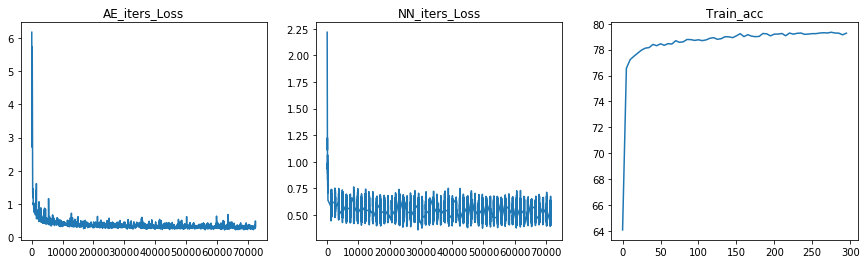

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
fig.set_figwidth(15)
fig.set_figwidth(15)

ax1.plot(iterations_AE, loss_graph_AE)
ax1.set_title("AE_iters_Loss")
ax2.plot(iterations_NN, loss_graph_NN)
ax2.set_title("NN_iters_Loss")
ax3.plot(iter_acc, acc_NN)
ax3.set_title("Train_acc")
plt.show()

In [16]:
def read_test_csv(file_name):
    test_data = pd.read_csv(file_name)
    X = test_data.iloc[:, 1:]
    return X

In [17]:
file_name = "test.csv"
test_data_X = read_test_csv(file_name)
test_data_X = torch.from_numpy(test_data_X.values.astype(np.float32))
loader_test = DataLoader(TensorDataset(test_data_X), batch_size = 256)

In [18]:
network_NN.eval()
result = np.zeros((test_data_X.shape[0], 9))
i = 0
for x_batch in loader_test:
    latent_X = network_AE.fc1(x_batch[0])
    outputs = network_NN(latent_X)
    predict = torch.exp(outputs)
    result[np.arange(i, min(i + 256, test_data_X.shape[0]))] = predict.data
    i += 256

In [19]:
df = pd.DataFrame(data = result, index = np.arange(1, test_data_X.shape[0] + 1), columns=word_to_ix.keys())
df.index.name = "id"

In [20]:
df.to_csv("result.csv", index = True)